### Problema de negócio:
Em meio a tantas negociações em nossa base de dados, algumas delas podem ser fraudulentas. Com valores consideráveisem jogo, é fundamental ajudar os tomadores de decisão a identificar padrões suspeitos e prevenir perdas financeiras.  Logo, deve-se criar um sistema inteligente que analise transações imobiliárias e gere um ranking de propriedades, destacando aquelas com maior risco de fraude. 

In [1]:
# Imports
import math
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
              
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings("ignore")

2025-03-06 13:04:24.708569: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Análise Exploratória

In [2]:
# Carrega os dados
df = pd.read_csv('dados/dataset.csv')

In [3]:
# Shape
df.shape

(1070994, 32)

In [4]:
# Amostra dos dados
df.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,NaN,NaN,21400000.0,4225500.0,9630000.0,4225500.0,9630000.0,4600.0,1 LIBERTY ISLAND,10004.0,X3,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,NaN,NaN,193800000.0,14310000.0,87210000.0,14310000.0,87210000.0,4600.0,1 ELLIS ISLAND,10004.0,X3,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,E,3.0,104686000.0,39008700.0,47108700.0,39008700.0,47108700.0,2191.0,MARGINAL STREET,10004.0,X1,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,NaN,2.0,39200000.0,15255000.0,17640000.0,15255000.0,17640000.0,2191.0,PIER 6,10004.0,X1,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,1260,NaN,1.0,272300000.0,121050000.0,122535000.0,121050000.0,122535000.0,2231.0,BATTERY PARK,10004.0,X1,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


In [5]:
# Resumo
print("Linhas: ", df.shape[0])
print("Colunas: ", df.shape[1])
print("\nVariáveis: \n", df.columns.tolist())
print("\nValores Ausentes: \n" , df.isnull().sum())
print("\nValores Únicos: \n", df.nunique())

Linhas:  1070994
Colunas:  32

Variáveis: 
 ['RECORD', 'BBLE', 'B', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND', 'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL', 'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2', 'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE']

Valores Ausentes: 
 RECORD            0
BBLE              0
B                 0
BLOCK             0
LOT               0
EASEMENT    1066358
OWNER         31745
BLDGCL            0
TAXCLASS          0
LTFRONT           0
LTDEPTH           0
EXT          716689
STORIES       56264
FULLVAL           0
AVLAND            0
AVTOT             0
EXLAND            0
EXTOT             0
EXCD1        432506
STADDR          676
ZIP           29890
EXMPTCL     1055415
BLDFRONT          0
BLDDEPTH          0
AVLAND2      788268
AVTOT2       788262
EXLAND2      983545
EXTOT2       940166
EXCD2        978046
PERIOD            0
YEAR              0
VA

In [6]:
# Trabalhar com cópia do dataframe
df_temp = df.copy()

In [7]:
# Contagem de valores ausentes
df_temp['ZIP'].isna().sum()

29890

In [8]:
# Calcular o valor da moda de zip e se não houver valor de moda substituir por 1
def calcula_moda(x):
    m = pd.Series.mode(x)
    if m.empty:
        x = np.array(range(1,11))
        return x[0]
    else:
        return m.values[0]

In [9]:
# Função de contagem para calcular a frequência do valor da moda de cada grupo
def contagem(x):
    return x.value_counts().head(1)

In [10]:
# Agrupando valores pela variável 'B' e 'BLOCK', usando as duas funções para criar dataframe auxiliar com o valor da moda para cada grupo
df_zip_group = df_temp.groupby(['B','BLOCK'])['ZIP'].agg(ZIP = calcula_moda, Count = contagem).reset_index()

In [11]:
# Verificando 
df_zip_group.head(15)

,B,BLOCK,ZIP,Count
0,1,1,10004.0,2
1,1,2,10004.0,2
2,1,3,10004.0,4
3,1,4,10004.0,53
4,1,5,10004.0,9
5,1,6,10004.0,2
6,1,7,10004.0,15
7,1,8,10004.0,6
8,1,9,10004.0,4
9,1,10,10004.0,8


In [12]:
# Função que preenche os registros ZIP ausentes através do dataframe auxiliar, a primeira moda de cada grupo
def preenche_moda(x):
    if pd.isnull(x['ZIP']):
        return df_zip_group[(df_zip_group['B'] == x['B']) & (df_zip_group['BLOCK'] == x['BLOCK'])]['ZIP'].values[0]
    else:
        return x['ZIP']

In [13]:
# Aplicando a função para preencher os valores 
df_temp['ZIP'] = df_temp.apply(preenche_moda, axis = 1)

In [14]:
# Verificando se restou valor NA
df_temp['ZIP'].isna().sum()

0

In [15]:
# Checa se a fórmula funcionou corretamente
df_temp[(df_temp['B']==1) & (df_temp['BLOCK']==36)]['ZIP']

6092    1.0
6093    1.0
6094    1.0
6095    1.0
Name: ZIP, dtype: float64

In [16]:
# Visualiza
df_temp.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,NaN,NaN,21400000.0,4225500.0,9630000.0,4225500.0,9630000.0,4600.0,1 LIBERTY ISLAND,10004.0,X3,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,NaN,NaN,193800000.0,14310000.0,87210000.0,14310000.0,87210000.0,4600.0,1 ELLIS ISLAND,10004.0,X3,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,E,3.0,104686000.0,39008700.0,47108700.0,39008700.0,47108700.0,2191.0,MARGINAL STREET,10004.0,X1,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,NaN,2.0,39200000.0,15255000.0,17640000.0,15255000.0,17640000.0,2191.0,PIER 6,10004.0,X1,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,1260,NaN,1.0,272300000.0,121050000.0,122535000.0,121050000.0,122535000.0,2231.0,BATTERY PARK,10004.0,X1,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


In [17]:
# Salva o DF resultante no disco
df_temp.to_csv('dados/dataset_zip_limpo.csv')

In [18]:
df_temp['ZIP'] = df_temp['ZIP'].astype(int).astype(str)

In [19]:
# Cria cópia da estrutura do dataframe
df_temp2 = df_temp.copy()

In [20]:
# Substituindo valores vazios por valores NaN para as etapas posteriores
df_temp2.replace(0, np.nan, inplace = True)

In [21]:
# Definindo a lista de variáveis a serem preenchidas
list_fill = ['FULLVAL', 'AVLAND', 'AVTOT', 'BLDFRONT', 'BLDDEPTH', 'LTFRONT', 'LTDEPTH']

In [22]:
# Contando o número de valores NA para cada uma das variáveis
for i in list_fill:
    print(i, "--> Número de valores ausentes:", df_temp2[i].isna().sum())

FULLVAL --> Número de valores ausentes: 13007
AVLAND --> Número de valores ausentes: 13009
AVTOT --> Número de valores ausentes: 13007
BLDFRONT --> Número de valores ausentes: 228815
BLDDEPTH --> Número de valores ausentes: 228853
LTFRONT --> Número de valores ausentes: 169108
LTDEPTH --> Número de valores ausentes: 170128


In [23]:
# Preenchendo os registros vazios com a mediana do grupo ZIP e BLDGCL se o tamanho do grupo for maior ou igual a 5
for i in list_fill:
    df_temp2[i] = (
        df_temp2.groupby(['ZIP', 'BLDGCL'])[i]
        .apply(lambda x: x.fillna(x.median()) if len(x) >= 5 else x)
        .reset_index(level=[0, 1], drop=True) # Alinha os índices com o DF original
    )

In [24]:
# Contando o número de valores NA para cada uma das variáveis
for i in list_fill:
    print(i, "--> Número de valores ausentes:", df_temp2[i].isna().sum())

FULLVAL --> Número de valores ausentes: 10191
AVLAND --> Número de valores ausentes: 10191
AVTOT --> Número de valores ausentes: 10191
BLDFRONT --> Número de valores ausentes: 75209
BLDDEPTH --> Número de valores ausentes: 75181
LTFRONT --> Número de valores ausentes: 16016
LTDEPTH --> Número de valores ausentes: 17755


In [25]:
# Preenchendo os registros vazios com a mediana do grupo ZIP e TAXCLASS se o tamanho do grupo for maior ou igual a 5
for i in list_fill:
    df_temp2[i] = (
        df_temp2.groupby(['ZIP', 'TAXCLASS'])[i]
        .apply(lambda x: x.fillna(x.median()) if len(x) >= 5 else x)
        .reset_index(level=[0, 1], drop=True)
    )

In [26]:
# Contando o número de valores NA para as variáveis
for i in list_fill:
    print(i, "--> Número de valores ausentes:", df_temp2[i].isna().sum())

FULLVAL --> Número de valores ausentes: 3705
AVLAND --> Número de valores ausentes: 3705
AVTOT --> Número de valores ausentes: 3705
BLDFRONT --> Número de valores ausentes: 31230
BLDDEPTH --> Número de valores ausentes: 30915
LTFRONT --> Número de valores ausentes: 3093
LTDEPTH --> Número de valores ausentes: 3147


In [27]:
# Preenchendo os registros ausentes com a mediana do grupo B e TAXCLASS se o tamanho do grupo for maior ou igual a 5
for i in list_fill:
    df_temp2[i] = (
        df_temp2.groupby(['B', 'TAXCLASS'])[i]
        .apply(lambda x: x.fillna(x.median()) if len(x) >= 5 else x)
        .reset_index(level=[0, 1], drop=True)  # Ajusta o índice para coincidir com o DataFrame original
    )

In [28]:
# Contando o número de valores NA para as variáveis
for i in list_fill:
    print(i, "--> Número de valores ausentes:", df_temp2[i].isna().sum())

FULLVAL --> Número de valores ausentes: 2
AVLAND --> Número de valores ausentes: 2
AVTOT --> Número de valores ausentes: 2
BLDFRONT --> Número de valores ausentes: 22317
BLDDEPTH --> Número de valores ausentes: 15712
LTFRONT --> Número de valores ausentes: 2
LTDEPTH --> Número de valores ausentes: 2


In [29]:
# Preenchendo os registros ausentes com a mediana do grupo B se o tamanho do grupo for maior ou igual a 5
for i in list_fill:
    df_temp2[i] = (
        df_temp2.groupby('B')[i]
        .apply(lambda x: x.fillna(x.median()) if len(x) >= 5 else x)
        .reset_index(drop=True)  # Remove o índice do groupby para evitar conflitos
    )


In [30]:
for i in list_fill:
    print(i, "--> Número de valores ausentes:", df_temp2[i].isna().sum())

FULLVAL --> Número de valores ausentes: 0
AVLAND --> Número de valores ausentes: 0
AVTOT --> Número de valores ausentes: 0
BLDFRONT --> Número de valores ausentes: 0
BLDDEPTH --> Número de valores ausentes: 0
LTFRONT --> Número de valores ausentes: 0
LTDEPTH --> Número de valores ausentes: 0


#### Limpando Valores Ausentes da variável STORIES 

In [31]:
# Checa valores ausentes
print('STORIES', "--> Número de valores ausentes:", df_temp2['STORIES'].isna().sum())

STORIES --> Número de valores ausentes: 56264


In [32]:
# Imputação da mediana com base nos grupos de ZIP e BLDGCL
df_temp2['STORIES'] = (
    df_temp2.groupby(['ZIP', 'BLDGCL'])['STORIES']
    .apply(lambda x: x.fillna(x.median()) if len(x) >= 5 else x)
    .reset_index(level=[0, 1], drop=True)
)


In [33]:
# Checa valores ausentes
print('STORIES', "--> Número de valores ausentes:", df_temp2['STORIES'].isna().sum())

STORIES --> Número de valores ausentes: 42114


In [34]:
# Imputação da mediana com base nos grupos de BLDGCL
df_temp2['STORIES'] = df_temp2.groupby(['BLDGCL'])['STORIES'].transform(
    lambda x: x.fillna(x.median()) if len(x) >= 5 else x
)


In [35]:
# Checa valores ausentes
print('STORIES', "--> Número de valores ausentes:", df_temp2['STORIES'].isna().sum())

STORIES --> Número de valores ausentes: 4280


In [36]:
# Imputação da mediana com base nos grupos de 'TAXCLASS' e 'STORIES'
df_temp2['STORIES'] = df_temp2.groupby(['TAXCLASS'])['STORIES'].transform(
    lambda x: x.fillna(x.median()) if len(x) >= 5 else x
)


In [37]:
# Checa valores ausentes
print('STORIES', "--> Número de valores ausentes:", df_temp2['STORIES'].isna().sum())

STORIES --> Número de valores ausentes: 0


### Engenharia de Atributos

In [38]:
# Cópia do dataframe
df_proc = df_temp2.copy()

In [39]:
# Área 1 = LTFRONT * LTDEPTH
df_proc['AREA1'] = df_proc['LTFRONT'] * df_proc['LTDEPTH']

In [40]:
# Visualiza amostra
df_proc[['AREA1', 'LTFRONT', 'LTDEPTH']].head()

,AREA1,LTFRONT,LTDEPTH
0,523000.0,500.0,1046.0
1,9585.0,27.0,355.0
2,399876.0,709.0,564.0
3,436943.0,793.0,551.0
4,406980.0,323.0,1260.0


In [41]:
# Área 2 = BLDFRONT * BLDDEPTH
df_proc['AREA2'] = df_proc['BLDFRONT'] * df_proc['BLDDEPTH']

In [42]:
# Visualiza amostra
df_proc[['AREA2', 'BLDFRONT', 'BLDDEPTH']].head()

,AREA2,BLDFRONT,BLDDEPTH
0,121476.0,382.0,318.0
1,121476.0,382.0,318.0
2,399876.0,709.0,564.0
3,46835.0,85.0,551.0
4,5073.0,89.0,57.0


In [43]:
# Área 3 = AREA2 * STORIES
df_proc['AREA3'] = df_proc['AREA2'] * df_proc['STORIES']

In [44]:
# Visualiza amostra
df_proc[['AREA2', 'STORIES', 'AREA3']].head()

,AREA2,STORIES,AREA3
0,121476.0,4.0,485904.0
1,121476.0,1.0,121476.0
2,399876.0,3.0,1199628.0
3,46835.0,2.0,93670.0
4,5073.0,1.0,5073.0


In [45]:
# Dividindo FULLVAL, AVLAND e AVTOT pelas variáveis recém criadas AREA1, AREA2 e AREA3 para gerar um índice
k = 1
for i in ['FULLVAL', 'AVLAND', 'AVTOT']:
    for j in ['AREA1', 'AREA2', 'AREA3']:
        indice_area = 'ind' + str(k)
        df_proc[indice_area] = df_proc[i] / df_proc[j]
        print(indice_area + ' é a combinação feita entre:', i, j)
        k += 1

ind1 é a combinação feita entre: FULLVAL AREA1
ind2 é a combinação feita entre: FULLVAL AREA2
ind3 é a combinação feita entre: FULLVAL AREA3
ind4 é a combinação feita entre: AVLAND AREA1
ind5 é a combinação feita entre: AVLAND AREA2
ind6 é a combinação feita entre: AVLAND AREA3
ind7 é a combinação feita entre: AVTOT AREA1
ind8 é a combinação feita entre: AVTOT AREA2
ind9 é a combinação feita entre: AVTOT AREA3


In [46]:
# Visualiza amostra
df_proc.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,AREA1,AREA2,AREA3,ind1,ind2,ind3,ind4,ind5,ind6,ind7,ind8,ind9
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.0,1046.0,NaN,4.0,21400000.0,4225500.0,9630000.0,4225500.0,9630000.0,4600.0,1 LIBERTY ISLAND,10004,X3,382.0,318.0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,523000.0,121476.0,485904.0,40.917782,176.166486,44.041621,8.079350,34.784649,8.696162,18.413002,79.274919,19.818730
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.0,355.0,NaN,1.0,193800000.0,14310000.0,87210000.0,14310000.0,87210000.0,4600.0,1 ELLIS ISLAND,10004,X3,382.0,318.0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,9585.0,121476.0,121476.0,20219.092332,1595.376865,1595.376865,1492.957746,117.801047,117.801047,9098.591549,717.919589,717.919589
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709.0,564.0,E,3.0,104686000.0,39008700.0,47108700.0,39008700.0,47108700.0,2191.0,MARGINAL STREET,10004,X1,709.0,564.0,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,399876.0,399876.0,1199628.0,261.796157,261.796157,87.265386,97.551991,97.551991,32.517330,117.808271,117.808271,39.269424
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793.0,551.0,NaN,2.0,39200000.0,15255000.0,17640000.0,15255000.0,17640000.0,2191.0,PIER 6,10004,X1,85.0,551.0,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,436943.0,46835.0,93670.0,89.714219,836.980890,418.490445,34.913021,325.717946,162.858973,40.371399,376.641401,188.320700
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323.0,1260.0,NaN,1.0,272300000.0,121050000.0,122535000.0,121050000.0,122535000.0,2231.0,BATTERY PARK,10004,X1,89.0,57.0,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,406980.0,5073.0,5073.0,669.074647,53676.325646,53676.325646,297.434763,23861.620343,23861.620343,301.083591,24154.346541,24154.346541


In [47]:
df_proc['ZIP'].dtype

dtype('O')

In [48]:
# Converter a variável zip para string
df_proc['ZIP'] = df_proc['ZIP'].astype(int).astype(str)

In [49]:
df_proc['ZIP'].dtype

dtype('O')

In [50]:
# Visualiza
df_proc.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,AREA1,AREA2,AREA3,ind1,ind2,ind3,ind4,ind5,ind6,ind7,ind8,ind9
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.0,1046.0,NaN,4.0,21400000.0,4225500.0,9630000.0,4225500.0,9630000.0,4600.0,1 LIBERTY ISLAND,10004,X3,382.0,318.0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,523000.0,121476.0,485904.0,40.917782,176.166486,44.041621,8.079350,34.784649,8.696162,18.413002,79.274919,19.818730
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.0,355.0,NaN,1.0,193800000.0,14310000.0,87210000.0,14310000.0,87210000.0,4600.0,1 ELLIS ISLAND,10004,X3,382.0,318.0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,9585.0,121476.0,121476.0,20219.092332,1595.376865,1595.376865,1492.957746,117.801047,117.801047,9098.591549,717.919589,717.919589
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709.0,564.0,E,3.0,104686000.0,39008700.0,47108700.0,39008700.0,47108700.0,2191.0,MARGINAL STREET,10004,X1,709.0,564.0,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,399876.0,399876.0,1199628.0,261.796157,261.796157,87.265386,97.551991,97.551991,32.517330,117.808271,117.808271,39.269424
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793.0,551.0,NaN,2.0,39200000.0,15255000.0,17640000.0,15255000.0,17640000.0,2191.0,PIER 6,10004,X1,85.0,551.0,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,436943.0,46835.0,93670.0,89.714219,836.980890,418.490445,34.913021,325.717946,162.858973,40.371399,376.641401,188.320700
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323.0,1260.0,NaN,1.0,272300000.0,121050000.0,122535000.0,121050000.0,122535000.0,2231.0,BATTERY PARK,10004,X1,89.0,57.0,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,406980.0,5073.0,5073.0,669.074647,53676.325646,53676.325646,297.434763,23861.620343,23861.620343,301.083591,24154.346541,24154.346541


In [51]:
# Lista das variáveis para o agrupamento abaixo
list_groupby = ['ZIP', 'TAXCLASS', 'B']

In [52]:
# Cria as variáveis que representam as médias das áreas dos imóveis por grupo com base no índice cria e normaliza

# Lista
ind_lista = ['ind' + str(i) for i in range(1,10)]

# Loop
for i in list_groupby:
    for j in ind_lista:
        name_col = 'media_' + str(j) + '_grupo_' + str(i)
        df_proc[name_col] = df_proc.groupby(i)[j].transform('mean')
        name_col_final = str(j) + '_' + name_col
        df_proc[name_col_final] = df_proc[j] / df_proc[name_col]

In [53]:
# Visualiza
df_proc.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,AREA1,AREA2,AREA3,ind1,ind2,ind3,ind4,ind5,ind6,ind7,ind8,ind9,media_ind1_grupo_ZIP,ind1_media_ind1_grupo_ZIP,media_ind2_grupo_ZIP,ind2_media_ind2_grupo_ZIP,media_ind3_grupo_ZIP,ind3_media_ind3_grupo_ZIP,media_ind4_grupo_ZIP,ind4_media_ind4_grupo_ZIP,media_ind5_grupo_ZIP,ind5_media_ind5_grupo_ZIP,media_ind6_grupo_ZIP,ind6_media_ind6_grupo_ZIP,media_ind7_grupo_ZIP,ind7_media_ind7_grupo_ZIP,media_ind8_grupo_ZIP,ind8_media_ind8_grupo_ZIP,media_ind9_grupo_ZIP,ind9_media_ind9_grupo_ZIP,media_ind1_grupo_TAXCLASS,ind1_media_ind1_grupo_TAXCLASS,media_ind2_grupo_TAXCLASS,ind2_media_ind2_grupo_TAXCLASS,media_ind3_grupo_TAXCLASS,ind3_media_ind3_grupo_TAXCLASS,media_ind4_grupo_TAXCLASS,ind4_media_ind4_grupo_TAXCLASS,media_ind5_grupo_TAXCLASS,ind5_media_ind5_grupo_TAXCLASS,media_ind6_grupo_TAXCLASS,ind6_media_ind6_grupo_TAXCLASS,media_ind7_grupo_TAXCLASS,ind7_media_ind7_grupo_TAXCLASS,media_ind8_grupo_TAXCLASS,ind8_media_ind8_grupo_TAXCLASS,media_ind9_grupo_TAXCLASS,ind9_media_ind9_grupo_TAXCLASS,media_ind1_grupo_B,ind1_media_ind1_grupo_B,media_ind2_grupo_B,ind2_media_ind2_grupo_B,media_ind3_grupo_B,ind3_media_ind3_grupo_B,media_ind4_grupo_B,ind4_media_ind4_grupo_B,media_ind5_grupo_B,ind5_media_ind5_grupo_B,media_ind6_grupo_B,ind6_media_ind6_grupo_B,media_ind7_grupo_B,ind7_media_ind7_grupo_B,media_ind8_grupo_B,ind8_media_ind8_grupo_B,media_ind9_grupo_B,ind9_media_ind9_grupo_B
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.0,1046.0,NaN,4.0,21400000.0,4225500.0,9630000.0,4225500.0,9630000.0,4600.0,1 LIBERTY ISLAND,10004,X3,382.0,318.0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,523000.0,121476.0,485904.0,40.917782,176.166486,44.041621,8.079350,34.784649,8.696162,18.413002,79.274919,19.818730,308.441225,0.132660,399.385741,0.441094,136.521085,0.322599,43.855587,0.184226,90.355784,0.384974,52.228975,0.166501,125.960056,0.146181,166.894536,0.475000,58.48534,0.338867,225.913152,0.181122,869.579633,0.202588,455.064419,0.096781,42.909019,0.188290,278.123781,0.125069,166.174482,0.052332,101.732571,0.180994,411.624116,0.192591,211.534909,0.093690,360.556764,0.113485,555.853523,0.316930,163.573759,0.269246,34.403482,0.234841,68.33207,0.509053,32.262614,0.269543,94.018189,0.195845,146.607592,0.540729,45.416674,0.436376
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.0,355.0,NaN,1.0,193800000.0,14310000.0,87210000.0,14310000.0,87210000.0,4600.0,1 ELLIS ISLAND,10004,X3,382.0,318.0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,9585.0,121476.0,121476.0,20219.092332,1595.376865,1595.376865,1492.957746,117.801047,117.801047,9098.591549,717.919589,717.919589,308.441225,65.552497,399.385741,3.994576,136.521085,11.685938,43.855587,34.042590,90.355784,1.303747,52.228975,2.255473,125.960056,72.233943,166.894536,4.301636,58.48534,12.275206,225.913152,89.499403,869.579633,1.834653,455.064419,3.505826,42.909019,34.793565,278.123781,0.423556,166.174482,0.708900,101.732571,89.436367,411.624116,1.744114,211.534909,3.393859,360.556764,56.077418,555.853523,2.870139,163.573759,9.753257,34.403482,43.395542,68.33207,1.723950,32.262614,3.651318,94.018189,96.774801,146.607592,4.896879,45.416674,15.807401
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709.0,564.0,E,3.0,104686000.0,39008700.0,47108700.0,39008700.0,47108700.0,2191.0,MARGINAL STREET,10004,X1,709.0,564.0,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,399876.0,399876.0,1199628.0,261.796157,261.796157,87.265386,97.551991,97.551991,32.517330,117.808271,117.808271,39.269424,308.441225,0.848772,399.385741,0.655497,136.521085,0.639208,43.855587,2.224391,90.355784,1.079643,52.228975,0.622592,125.960056,0.935283,166.894536,0.705885,58.48534,0.671440,225.913152,1.158835,869.579633,0.301061,455.064419,0.191765,42.909019,2.2

In [54]:
# Shape
df_proc.shape

(1070994, 98)

In [55]:
# Média para todas as variáveis
for j in ind_lista:
    name_col = 'media_' + str(j) + '_grupo_All'
    df_proc[name_col] = df_proc[j].mean()
    name_col_final = str(j) + '_' + name_col
    df_proc[name_col_final] = df_proc[j] / df_proc[name_col]

In [56]:
# Shape
df_proc.shape

(1070994, 116)

In [57]:
# Visualiza
df_proc.head(20)

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,AREA1,AREA2,AREA3,ind1,ind2,ind3,ind4,ind5,ind6,ind7,ind8,ind9,media_ind1_grupo_ZIP,ind1_media_ind1_grupo_ZIP,media_ind2_grupo_ZIP,ind2_media_ind2_grupo_ZIP,media_ind3_grupo_ZIP,ind3_media_ind3_grupo_ZIP,media_ind4_grupo_ZIP,ind4_media_ind4_grupo_ZIP,media_ind5_grupo_ZIP,ind5_media_ind5_grupo_ZIP,media_ind6_grupo_ZIP,ind6_media_ind6_grupo_ZIP,media_ind7_grupo_ZIP,ind7_media_ind7_grupo_ZIP,media_ind8_grupo_ZIP,ind8_media_ind8_grupo_ZIP,media_ind9_grupo_ZIP,ind9_media_ind9_grupo_ZIP,media_ind1_grupo_TAXCLASS,ind1_media_ind1_grupo_TAXCLASS,media_ind2_grupo_TAXCLASS,ind2_media_ind2_grupo_TAXCLASS,media_ind3_grupo_TAXCLASS,ind3_media_ind3_grupo_TAXCLASS,media_ind4_grupo_TAXCLASS,ind4_media_ind4_grupo_TAXCLASS,media_ind5_grupo_TAXCLASS,ind5_media_ind5_grupo_TAXCLASS,media_ind6_grupo_TAXCLASS,ind6_media_ind6_grupo_TAXCLASS,media_ind7_grupo_TAXCLASS,ind7_media_ind7_grupo_TAXCLASS,media_ind8_grupo_TAXCLASS,ind8_media_ind8_grupo_TAXCLASS,media_ind9_grupo_TAXCLASS,ind9_media_ind9_grupo_TAXCLASS,media_ind1_grupo_B,ind1_media_ind1_grupo_B,media_ind2_grupo_B,ind2_media_ind2_grupo_B,media_ind3_grupo_B,ind3_media_ind3_grupo_B,media_ind4_grupo_B,ind4_media_ind4_grupo_B,media_ind5_grupo_B,ind5_media_ind5_grupo_B,media_ind6_grupo_B,ind6_media_ind6_grupo_B,media_ind7_grupo_B,ind7_media_ind7_grupo_B,media_ind8_grupo_B,ind8_media_ind8_grupo_B,media_ind9_grupo_B,ind9_media_ind9_grupo_B,media_ind1_grupo_All,ind1_media_ind1_grupo_All,media_ind2_grupo_All,ind2_media_ind2_grupo_All,media_ind3_grupo_All,ind3_media_ind3_grupo_All,media_ind4_grupo_All,ind4_media_ind4_grupo_All,media_ind5_grupo_All,ind5_media_ind5_grupo_All,media_ind6_grupo_All,ind6_media_ind6_grupo_All,media_ind7_grupo_All,ind7_media_ind7_grupo_All,media_ind8_grupo_All,ind8_media_ind8_grupo_All,media_ind9_grupo_All,ind9_media_ind9_grupo_All
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.0,1046.0,NaN,4.0,21400000.0,4225500.0,9630000.0,4225500.0,9630000.0,4600.0,1 LIBERTY ISLAND,10004,X3,382.0,318.0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,523000.0,121476.0,485904.0,40.917782,176.166486,44.041621,8.079350,34.784649,8.696162,18.413002,79.274919,19.818730,308.441225,0.132660,399.385741,0.441094,136.521085,0.322599,43.855587,0.184226,90.355784,0.384974,52.228975,0.166501,125.960056,0.146181,166.894536,0.475000,58.48534,0.338867,225.913152,0.181122,869.579633,0.202588,455.064419,0.096781,42.909019,0.188290,278.123781,0.125069,166.174482,0.052332,101.732571,0.180994,411.624116,0.192591,211.534909,0.093690,360.556764,0.113485,555.853523,0.316930,163.573759,0.269246,34.403482,0.234841,68.33207,0.509053,32.262614,0.269543,94.018189,0.195845,146.607592,0.540729,45.416674,0.436376,343.478797,0.119128,607.713499,0.289884,284.102431,0.155020,11.120478,0.726529,44.456405,0.782444,24.191611,0.359470,30.611521,0.601506,75.921598,1.044168,34.677974,0.571508
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.0,355.0,NaN,1.0,193800000.0,14310000.0,87210000.0,14310000.0,87210000.0,4600.0,1 ELLIS ISLAND,10004,X3,382.0,318.0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,9585.0,121476.0,121476.0,20219.092332,1595.376865,1595.376865,1492.957746,117.801047,117.801047,9098.591549,717.919589,717.919589,308.441225,65.552497,399.385741,3.994576,136.521085,11.685938,43.855587,34.042590,90.355784,1.303747,52.228975,2.255473,125.960056,72.233943,166.894536,4.301636,58.48534,12.275206,225.913152,89.499403,869.579633,1.834653,455.064419,3.505826,42.909019,34.793565,278.123781,0.423556,166.174482,0.708900,101.732571,89.436367,411.624116,1.744114,211.534909,3.393859,360.556764,56.077418,555.853523,2.870139,163.573759,9.753257,34.403482,43.395542,68.33207,1.723950,32.262614,3.651318,94.018189,96.774801,146.607592,4.896879,45.416674,15.807401,343.478797,

In [58]:
# Lista para as colunas criadas
cols_created = []

In [59]:
# Loop pelas variáveis do group by
for i in list_groupby:
    for j in ind_lista:
        cols_created.append(j + '_media_' + j + '_grupo_' + i)

In [60]:
len(cols_created)

27

In [61]:
# Loop pelas colunas criadas
for j in ind_lista:
    cols_created.append(j + '_media_' + j + '_grupo_All')

In [62]:
len(cols_created)

36

In [63]:
# Colunas finais para os dados
cols = list(df.columns) + cols_created

In [64]:
# Dataframe final
df_final = df_proc[cols]

In [65]:
# Shape
df_final.shape

(1070994, 68)

In [66]:
# Colunas
df_final.columns

Index(['RECORD', 'BBLE', 'B', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'ind1_media_ind1_grupo_ZIP',
       'ind2_media_ind2_grupo_ZIP', 'ind3_media_ind3_grupo_ZIP',
       'ind4_media_ind4_grupo_ZIP', 'ind5_media_ind5_grupo_ZIP',
       'ind6_media_ind6_grupo_ZIP', 'ind7_media_ind7_grupo_ZIP',
       'ind8_media_ind8_grupo_ZIP', 'ind9_media_ind9_grupo_ZIP',
       'ind1_media_ind1_grupo_TAXCLASS', 'ind2_media_ind2_grupo_TAXCLASS',
       'ind3_media_ind3_grupo_TAXCLASS', 'ind4_media_ind4_grupo_TAXCLASS',
       'ind5_media_ind5_grupo_TAXCLASS', 'ind6_media_ind6_grupo_TAXCLASS',
       'ind7_media_ind7_grupo_TAXCLASS', 'ind8_media_ind8_grupo_TAXCLASS',
       'ind9_media_ind9_grupo_TAXCLASS', 'ind1_media_ind1_grupo_

In [67]:
# Visualiza
df_final.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,ind1_media_ind1_grupo_ZIP,ind2_media_ind2_grupo_ZIP,ind3_media_ind3_grupo_ZIP,ind4_media_ind4_grupo_ZIP,ind5_media_ind5_grupo_ZIP,ind6_media_ind6_grupo_ZIP,ind7_media_ind7_grupo_ZIP,ind8_media_ind8_grupo_ZIP,ind9_media_ind9_grupo_ZIP,ind1_media_ind1_grupo_TAXCLASS,ind2_media_ind2_grupo_TAXCLASS,ind3_media_ind3_grupo_TAXCLASS,ind4_media_ind4_grupo_TAXCLASS,ind5_media_ind5_grupo_TAXCLASS,ind6_media_ind6_grupo_TAXCLASS,ind7_media_ind7_grupo_TAXCLASS,ind8_media_ind8_grupo_TAXCLASS,ind9_media_ind9_grupo_TAXCLASS,ind1_media_ind1_grupo_B,ind2_media_ind2_grupo_B,ind3_media_ind3_grupo_B,ind4_media_ind4_grupo_B,ind5_media_ind5_grupo_B,ind6_media_ind6_grupo_B,ind7_media_ind7_grupo_B,ind8_media_ind8_grupo_B,ind9_media_ind9_grupo_B,ind1_media_ind1_grupo_All,ind2_media_ind2_grupo_All,ind3_media_ind3_grupo_All,ind4_media_ind4_grupo_All,ind5_media_ind5_grupo_All,ind6_media_ind6_grupo_All,ind7_media_ind7_grupo_All,ind8_media_ind8_grupo_All,ind9_media_ind9_grupo_All
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.0,1046.0,NaN,4.0,21400000.0,4225500.0,9630000.0,4225500.0,9630000.0,4600.0,1 LIBERTY ISLAND,10004,X3,382.0,318.0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,0.132660,0.441094,0.322599,0.184226,0.384974,0.166501,0.146181,0.475000,0.338867,0.181122,0.202588,0.096781,0.188290,0.125069,0.052332,0.180994,0.192591,0.093690,0.113485,0.316930,0.269246,0.234841,0.509053,0.269543,0.195845,0.540729,0.436376,0.119128,0.289884,0.155020,0.726529,0.782444,0.359470,0.601506,1.044168,0.571508
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.0,355.0,NaN,1.0,193800000.0,14310000.0,87210000.0,14310000.0,87210000.0,4600.0,1 ELLIS ISLAND,10004,X3,382.0,318.0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,65.552497,3.994576,11.685938,34.042590,1.303747,2.255473,72.233943,4.301636,12.275206,89.499403,1.834653,3.505826,34.793565,0.423556,0.708900,89.436367,1.744114,3.393859,56.077418,2.870139,9.753257,43.395542,1.723950,3.651318,96.774801,4.896879,15.807401,58.865620,2.625212,5.615499,134.253016,2.649810,4.869500,297.227681,9.456065,20.702466
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709.0,564.0,E,3.0,104686000.0,39008700.0,47108700.0,39008700.0,47108700.0,2191.0,MARGINAL STREET,10004,X1,709.0,564.0,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,0.848772,0.655497,0.639208,2.224391,1.079643,0.622592,0.935283,0.705885,0.671440,1.158835,0.301061,0.191765,2.273461,0.350750,0.195682,1.158019,0.286204,0.185640,0.726089,0.470980,0.533493,2.835527,1.427617,1.007895,1.253037,0.803562,0.864648,0.762190,0.430789,0.307162,8.772284,2.194329,1.344157,3.848494,1.551710,1.132402
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793.0,551.0,NaN,2.0,39200000.0,15255000.0,17640000.0,15255000.0,17640000.0,2191.0,PIER 6,10004,X1,85.0,551.0,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,0.290863,2.095670,3.065391,0.796091,3.604838,3.118173,0.320510,2.256763,3.219964,0.397118,0.962512,0.919629,0.813652,1.171126,0.980048,0.396838,0.915013,0.890258,0.248821,1.505758,2.558420,1.014811,4.766692,5.047916,0.429400,2.569044,4.146510,0.261193,1.377262,1.473027,3.139525,7.326682,6.732043,1.318830,4.960926,5.430557
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323.0,1260.0,NaN,1.0,272300000.0,121050000.0,122535000.0,121050000.0,122535000.0,2231.0,BATTERY PARK,10004,X1,89.0,57.0,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,2.169213,134.397201,393.172423,6.782141,264.085147,456.865570,2.390310,144.728204,412.998307,2.961645,61.726751,117.953247,6.931754,85.794966,143.593770,2.959559,58.680591,114.186101,1.855671,96.565594,328.147535,8.645484,349.200900,739.605921,3.202397,164.755087,531.838735,1.947936,88.325051,188.933004,26.746580,536.7

In [68]:
# Dataframe final para a modelagem
df = df_final.copy()

### Calculando o Score de Fraude 1 com PCA

Será criado um score de fraude usando PCA em escala Z.

#### Padronização das Variáveis

In [69]:
# Shape
df.shape

(1070994, 68)

In [70]:
# Tipos de dados
df.dtypes

RECORD                              int64
BBLE                               object
B                                   int64
BLOCK                               int64
LOT                                 int64
EASEMENT                           object
OWNER                              object
BLDGCL                             object
TAXCLASS                           object
LTFRONT                           float64
LTDEPTH                           float64
EXT                                object
STORIES                           float64
FULLVAL                           float64
AVLAND                            float64
AVTOT                             float64
EXLAND                            float64
EXTOT                             float64
EXCD1                             float64
STADDR                             object
ZIP                                object
EXMPTCL                            object
BLDFRONT                          float64
BLDDEPTH                          

In [71]:
# Busca as 36 últimas colunas
df.iloc[:,-36:].columns

Index(['ind1_media_ind1_grupo_ZIP', 'ind2_media_ind2_grupo_ZIP',
       'ind3_media_ind3_grupo_ZIP', 'ind4_media_ind4_grupo_ZIP',
       'ind5_media_ind5_grupo_ZIP', 'ind6_media_ind6_grupo_ZIP',
       'ind7_media_ind7_grupo_ZIP', 'ind8_media_ind8_grupo_ZIP',
       'ind9_media_ind9_grupo_ZIP', 'ind1_media_ind1_grupo_TAXCLASS',
       'ind2_media_ind2_grupo_TAXCLASS', 'ind3_media_ind3_grupo_TAXCLASS',
       'ind4_media_ind4_grupo_TAXCLASS', 'ind5_media_ind5_grupo_TAXCLASS',
       'ind6_media_ind6_grupo_TAXCLASS', 'ind7_media_ind7_grupo_TAXCLASS',
       'ind8_media_ind8_grupo_TAXCLASS', 'ind9_media_ind9_grupo_TAXCLASS',
       'ind1_media_ind1_grupo_B', 'ind2_media_ind2_grupo_B',
       'ind3_media_ind3_grupo_B', 'ind4_media_ind4_grupo_B',
       'ind5_media_ind5_grupo_B', 'ind6_media_ind6_grupo_B',
       'ind7_media_ind7_grupo_B', 'ind8_media_ind8_grupo_B',
       'ind9_media_ind9_grupo_B', 'ind1_media_ind1_grupo_All',
       'ind2_media_ind2_grupo_All', 'ind3_media_ind3_grupo_All'

In [72]:
# Cria o objeto scaler
scaler = preprocessing.StandardScaler()

In [73]:
# Aplica o scaler às variáveis
arr_scaled = scaler.fit_transform(df.iloc[:,-36:])

In [74]:
# Cria o dataframe
df_scaled = pd.DataFrame(arr_scaled, columns = cols_created)

In [75]:
# Visualiza a amostra
df_scaled.head()

,ind1_media_ind1_grupo_ZIP,ind2_media_ind2_grupo_ZIP,ind3_media_ind3_grupo_ZIP,ind4_media_ind4_grupo_ZIP,ind5_media_ind5_grupo_ZIP,ind6_media_ind6_grupo_ZIP,ind7_media_ind7_grupo_ZIP,ind8_media_ind8_grupo_ZIP,ind9_media_ind9_grupo_ZIP,ind1_media_ind1_grupo_TAXCLASS,ind2_media_ind2_grupo_TAXCLASS,ind3_media_ind3_grupo_TAXCLASS,ind4_media_ind4_grupo_TAXCLASS,ind5_media_ind5_grupo_TAXCLASS,ind6_media_ind6_grupo_TAXCLASS,ind7_media_ind7_grupo_TAXCLASS,ind8_media_ind8_grupo_TAXCLASS,ind9_media_ind9_grupo_TAXCLASS,ind1_media_ind1_grupo_B,ind2_media_ind2_grupo_B,ind3_media_ind3_grupo_B,ind4_media_ind4_grupo_B,ind5_media_ind5_grupo_B,ind6_media_ind6_grupo_B,ind7_media_ind7_grupo_B,ind8_media_ind8_grupo_B,ind9_media_ind9_grupo_B,ind1_media_ind1_grupo_All,ind2_media_ind2_grupo_All,ind3_media_ind3_grupo_All,ind4_media_ind4_grupo_All,ind5_media_ind5_grupo_All,ind6_media_ind6_grupo_All,ind7_media_ind7_grupo_All,ind8_media_ind8_grupo_All,ind9_media_ind9_grupo_All
0,-0.208351,-0.059289,-0.066672,-0.066594,-0.024514,-0.032140,-0.090158,-0.025139,-0.030569,-0.123767,-0.032407,-0.010874,-0.071881,-0.014294,-0.006843,-0.108039,-0.031691,-0.010889,-0.060376,-0.046637,-0.041309,-0.017299,-0.006081,-0.009236,-0.042837,-0.007646,-0.009622,-0.039995,-0.045696,-0.049239,-0.007835,-0.002792,-0.007831,-0.024244,0.000768,-0.006957
1,15.506713,0.317667,1.051744,2.697348,0.012107,0.048412,7.521834,0.158098,0.521330,13.376017,0.033920,0.030168,2.992595,-0.009418,-0.002102,11.666117,0.029207,0.028760,3.751024,0.127685,0.494821,0.958493,0.008967,0.033524,5.101825,0.064876,0.252787,2.627338,0.104582,0.268956,3.817661,0.021175,0.047305,18.022103,0.146993,0.319909
2,-0.036328,-0.036545,-0.035510,0.099950,0.003174,-0.014553,-0.006834,-0.014084,-0.015192,0.024007,-0.028405,-0.009731,0.112772,-0.010607,-0.005808,0.020845,-0.028017,-0.009784,-0.018655,-0.036119,-0.026372,0.041498,0.005296,0.000100,0.013479,-0.003270,-0.002311,-0.010798,-0.036629,-0.040373,0.222674,0.015329,0.004207,0.173299,0.009590,0.002150
3,-0.170348,0.116230,0.203282,-0.016646,0.103825,0.081679,-0.071750,0.060180,0.102644,-0.091121,-0.001524,-0.000968,-0.016502,0.002796,-0.000144,-0.079566,-0.003336,-0.001318,-0.051159,0.034531,0.088097,0.000335,0.046653,0.051184,-0.030395,0.026122,0.053716,-0.033545,0.024277,0.027564,0.061297,0.081203,0.070075,0.019397,0.068853,0.071939
4,0.280867,14.150884,38.598860,0.472010,10.486183,17.578565,0.146808,6.882379,19.049502,0.296488,2.467932,1.408026,0.525287,1.385351,1.029648,0.258496,2.264010,1.359831,0.058275,6.524799,18.493638,0.172852,4.312740,9.339271,0.117319,2.726223,9.062305,0.043040,5.619347,10.951294,0.737632,6.876210,12.046167,0.537548,5.513027,11.293378


### Aplicando PCA

In [76]:
# Cria e treina o modelo PCA para encontrar o valor ideal de componentes principais
pca = PCA().fit(df_scaled)

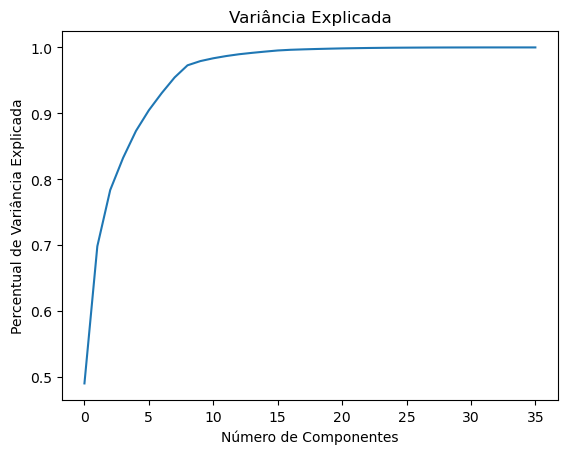

In [77]:
# Visualiza a Soma Cumulativa da Variância Explicada
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Percentual de Variância Explicada') 
plt.title('Variância Explicada')
plt.show()

In [78]:
# Usaremos 15 componentes
pca = PCA(n_components = 15)

In [79]:
# Fit e transform do modelo pca
arr_pca = pca.fit_transform(df_scaled)

In [80]:
# Cria a lista colunas doo PCA
cols_PCA = ['PCA' + str(i) for i in range(1,16)]
cols_PCA

['PCA1',
 'PCA2',
 'PCA3',
 'PCA4',
 'PCA5',
 'PCA6',
 'PCA7',
 'PCA8',
 'PCA9',
 'PCA10',
 'PCA11',
 'PCA12',
 'PCA13',
 'PCA14',
 'PCA15']

In [81]:
# Armazena os componentes em um dataframe
df_scaled_pca = pd.DataFrame(arr_pca, columns = cols_PCA)

In [82]:
# Visualiza amostra
df_scaled_pca.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15
0,-0.178749,-0.205514,-0.033748,0.012775,-0.026183,-0.113527,0.131550,-0.063331,-0.032705,0.006533,-0.011059,-0.025792,-0.043961,0.013703,-0.052571
1,7.305372,24.802876,5.628007,-0.165964,1.138569,3.948332,-6.428461,0.932291,-1.843962,-1.259075,-1.003922,1.511822,-3.433822,-2.709633,13.251001
2,-0.007857,0.204411,0.012988,-0.074056,0.009563,-0.078260,0.148611,-0.064273,-0.023294,-0.000761,-0.005604,-0.033086,-0.118842,-0.015851,0.017772
3,0.229405,-0.178396,-0.137957,0.052896,0.098042,0.005009,0.183300,0.035698,-0.039502,0.003979,0.005118,0.072622,-0.116815,0.017643,-0.041205
4,44.485411,-8.732817,-11.174773,7.191817,19.592125,8.440973,5.188189,19.711273,-4.432929,-4.053650,7.795655,13.843679,-6.967180,4.359246,1.569485


#### Aplicação da Escala Z em Componentes PCA Padronizados

In [83]:
# Fit e transform nos dados
arr_pca_scaled_z = scaler.fit_transform(df_scaled_pca)

In [84]:
# Cria o dataframe
df_pca_scaled_z = pd.DataFrame(arr_pca_scaled_z, columns = cols_PCA)

In [85]:
# Visualiza
df_pca_scaled_z.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15
0,-0.042541,-0.075095,-0.019268,0.009635,-0.021584,-0.106870,0.135753,-0.068573,-0.040219,0.013587,-0.028282,-0.074056,-0.139887,0.049906,-0.202057
1,1.738639,9.063036,3.213283,-0.125173,0.938589,3.716785,-6.633883,1.009457,-2.267579,-2.618433,-2.567539,4.340826,-10.926674,-9.868170,50.930402
2,-0.001870,0.074692,0.007415,-0.055854,0.007883,-0.073671,0.153360,-0.069593,-0.028645,-0.001582,-0.014332,-0.094999,-0.378164,-0.057729,0.068306
3,0.054597,-0.065186,-0.078766,0.039895,0.080822,0.004716,0.189158,0.038653,-0.048576,0.008274,0.013088,0.208516,-0.371714,0.064255,-0.158371
4,10.587284,-3.190994,-6.380182,5.424181,16.150943,7.945959,5.353977,21.342767,-5.451315,-8.430165,19.937443,39.748728,-22.170080,15.875871,6.032338


#### Calculando o Fraud Score

In [86]:
# Loop para calcular o score por componente PCA
for i in range(1,16):
    col_name = 'score' + str(i)
    pca_col_name = 'PCA' + str(i)
    df_pca_scaled_z[col_name] = df_pca_scaled_z[pca_col_name] ** 2 

In [87]:
# Visualiza
df_pca_scaled_z.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,score1,score2,score3,score4,score5,score6,score7,score8,score9,score10,score11,score12,score13,score14,score15
0,-0.042541,-0.075095,-0.019268,0.009635,-0.021584,-0.106870,0.135753,-0.068573,-0.040219,0.013587,-0.028282,-0.074056,-0.139887,0.049906,-0.202057,0.001810,0.005639,0.000371,0.000093,0.000466,0.011421,0.018429,0.004702,0.001618,0.000185,0.000800,0.005484,0.019568,0.002491,0.040827
1,1.738639,9.063036,3.213283,-0.125173,0.938589,3.716785,-6.633883,1.009457,-2.267579,-2.618433,-2.567539,4.340826,-10.926674,-9.868170,50.930402,3.022864,82.138622,10.325188,0.015668,0.880950,13.814493,44.008407,1.019003,5.141913,6.856190,6.592255,18.842769,119.392208,97.380785,2593.905831
2,-0.001870,0.074692,0.007415,-0.055854,0.007883,-0.073671,0.153360,-0.069593,-0.028645,-0.001582,-0.014332,-0.094999,-0.378164,-0.057729,0.068306,0.000003,0.005579,0.000055,0.003120,0.000062,0.005427,0.023519,0.004843,0.000821,0.000003,0.000205,0.009025,0.143008,0.003333,0.004666
3,0.054597,-0.065186,-0.078766,0.039895,0.080822,0.004716,0.189158,0.038653,-0.048576,0.008274,0.013088,0.208516,-0.371714,0.064255,-0.158371,0.002981,0.004249,0.006204,0.001592,0.006532,0.000022,0.035781,0.001494,0.002360,0.000068,0.000171,0.043479,0.138172,0.004129,0.025081
4,10.587284,-3.190994,-6.380182,5.424181,16.150943,7.945959,5.353977,21.342767,-5.451315,-8.430165,19.937443,39.748728,-22.170080,15.875871,6.032338,112.090589,10.182445,40.706721,29.421736,260.852965,63.138266,28.665074,455.513704,29.716839,71.067684,397.501616,1579.961385,491.512453,252.043288,36.389107


In [88]:
# Colunas
col_scores = ['score' + str(i) for i in range(1,16)]

In [89]:
# Calcula o score de fraude
df_pca_scaled_z['Fraud Score 1'] = df_pca_scaled_z[col_scores].sum(axis = 1) ** (1 / 2)

In [90]:
# Visualiza
df_pca_scaled_z.head(10)

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,score1,score2,score3,score4,score5,score6,score7,score8,score9,score10,score11,score12,score13,score14,score15,Fraud Score 1
0,-0.042541,-0.075095,-0.019268,0.009635,-0.021584,-0.106870,0.135753,-0.068573,-0.040219,0.013587,-0.028282,-0.074056,-0.139887,0.049906,-0.202057,0.001810,0.005639,0.000371,0.000093,0.000466,0.011421,0.018429,0.004702,0.001618,0.000185,0.000800,0.005484,0.019568,0.002491,0.040827,0.337496
1,1.738639,9.063036,3.213283,-0.125173,0.938589,3.716785,-6.633883,1.009457,-2.267579,-2.618433,-2.567539,4.340826,-10.926674,-9.868170,50.930402,3.022864,82.138622,10.325188,0.015668,0.880950,13.814493,44.008407,1.019003,5.141913,6.856190,6.592255,18.842769,119.392208,97.380785,2593.905831,54.802711
2,-0.001870,0.074692,0.007415,-0.055854,0.007883,-0.073671,0.153360,-0.069593,-0.028645,-0.001582,-0.014332,-0.094999,-0.378164,-0.057729,0.068306,0.000003,0.005579,0.000055,0.003120,0.000062,0.005427,0.023519,0.004843,0.000821,0.000003,0.000205,0.009025,0.143008,0.003333,0.004666,0.451297
3,0.054597,-0.065186,-0.078766,0.039895,0.080822,0.004716,0.189158,0.038653,-0.048576,0.008274,0.013088,0.208516,-0.371714,0.064255,-0.158371,0.002981,0.004249,0.006204,0.001592,0.006532,0.000022,0.035781,0.001494,0.002360,0.000068,0.000171,0.043479,0.138172,0.004129,0.025081,0.521838
4,10.587284,-3.190994,-6.380182,5.424181,16.150943,7.945959,5.353977,21.342767,-5.451315,-8.430165,19.937443,39.748728,-22.170080,15.875871,6.032338,112.090589,10.182445,40.706721,29.421736,260.852965,63.138266,28.665074,455.513704,29.716839,71.067684,397.501616,1579.961385,491.512453,252.043288,36.389107,62.118949
5,-0.005339,0.105796,0.023448,-0.090299,0.020961,-0.109011,0.176330,-0.053422,-0.030497,-0.036199,0.059838,-0.138884,-0.414679,-0.024510,0.022814,0.000029,0.011193,0.000550,0.008154,0.000439,0.011883,0.031092,0.002854,0.000930,0.001310,0.003581,0.019289,0.171959,0.000601,0.000520,0.514183
6,5.469435,-1.869435,-3.380909,2.913923,8.424855,4.007023,2.818184,11.067343,-2.913321,-4.187650,10.443407,20.595586,-11.337249,8.397562,2.843549,29.914722,3.494787,11.430548,8.490945,70.978184,16.056233,7.942162,122.486073,8.487440,17.536409,109.064755,424.178183,128.533226,70.519049,8.085770,32.205566
7,0.336863,0.102144,-0.241358,0.085589,0.231177,0.468086,0.311947,0.078865,0.040863,0.183268,-0.325363,0.788744,-1.117037,-0.300778,0.197698,0.113477,0.010433,0.058253,0.007325,0.053443,0.219104,0.097311,0.006220,0.001670,0.033587,0.105861,0.622118,1.247772,0.090467,0.039084,1.645031
8,-0.056272,-0.079864,-0.011224,0.004301,-0.026941,-0.135927,0.130017,-0.077209,-0.046091,0.024391,-0.007572,-0.120417,-0.105879,0.058039,-0.219114,0.003167,0.006378,0.000126,0.000019,0.000726,0.018476,0.016904,0.005961,0.002124,0.000595,0.000057,0.014500,0.011210,0.003368,0.048011,0.362800
9,-0.054491,-0.073969,-0.010162,0.003761,-0.027100,-0.131523,0.127655,-0.078232,-0.045689,0.023702,-0.012746,-0.118241,-0.113890,0.050632,-0.194742,0.002969,0.005471,0.000103,0.000014,0.000734,0.017298,0.016296,0.006120,0.002088,0.000562,0.000162,0.013981,0.012971,0.002564,0.037925,0.345338


In [91]:
# Dataframe final com o score
df_score1 = pd.merge(df, df_pca_scaled_z.iloc[:,-1], left_index = True, right_index = True)

In [92]:
# Shape
df_score1.shape

(1070994, 69)

In [93]:
# Visualiza
df_score1.head()

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,ind1_media_ind1_grupo_ZIP,ind2_media_ind2_grupo_ZIP,ind3_media_ind3_grupo_ZIP,ind4_media_ind4_grupo_ZIP,ind5_media_ind5_grupo_ZIP,ind6_media_ind6_grupo_ZIP,ind7_media_ind7_grupo_ZIP,ind8_media_ind8_grupo_ZIP,ind9_media_ind9_grupo_ZIP,ind1_media_ind1_grupo_TAXCLASS,ind2_media_ind2_grupo_TAXCLASS,ind3_media_ind3_grupo_TAXCLASS,ind4_media_ind4_grupo_TAXCLASS,ind5_media_ind5_grupo_TAXCLASS,ind6_media_ind6_grupo_TAXCLASS,ind7_media_ind7_grupo_TAXCLASS,ind8_media_ind8_grupo_TAXCLASS,ind9_media_ind9_grupo_TAXCLASS,ind1_media_ind1_grupo_B,ind2_media_ind2_grupo_B,ind3_media_ind3_grupo_B,ind4_media_ind4_grupo_B,ind5_media_ind5_grupo_B,ind6_media_ind6_grupo_B,ind7_media_ind7_grupo_B,ind8_media_ind8_grupo_B,ind9_media_ind9_grupo_B,ind1_media_ind1_grupo_All,ind2_media_ind2_grupo_All,ind3_media_ind3_grupo_All,ind4_media_ind4_grupo_All,ind5_media_ind5_grupo_All,ind6_media_ind6_grupo_All,ind7_media_ind7_grupo_All,ind8_media_ind8_grupo_All,ind9_media_ind9_grupo_All,Fraud Score 1
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.0,1046.0,NaN,4.0,21400000.0,4225500.0,9630000.0,4225500.0,9630000.0,4600.0,1 LIBERTY ISLAND,10004,X3,382.0,318.0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,0.132660,0.441094,0.322599,0.184226,0.384974,0.166501,0.146181,0.475000,0.338867,0.181122,0.202588,0.096781,0.188290,0.125069,0.052332,0.180994,0.192591,0.093690,0.113485,0.316930,0.269246,0.234841,0.509053,0.269543,0.195845,0.540729,0.436376,0.119128,0.289884,0.155020,0.726529,0.782444,0.359470,0.601506,1.044168,0.571508,0.337496
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.0,355.0,NaN,1.0,193800000.0,14310000.0,87210000.0,14310000.0,87210000.0,4600.0,1 ELLIS ISLAND,10004,X3,382.0,318.0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,65.552497,3.994576,11.685938,34.042590,1.303747,2.255473,72.233943,4.301636,12.275206,89.499403,1.834653,3.505826,34.793565,0.423556,0.708900,89.436367,1.744114,3.393859,56.077418,2.870139,9.753257,43.395542,1.723950,3.651318,96.774801,4.896879,15.807401,58.865620,2.625212,5.615499,134.253016,2.649810,4.869500,297.227681,9.456065,20.702466,54.802711
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709.0,564.0,E,3.0,104686000.0,39008700.0,47108700.0,39008700.0,47108700.0,2191.0,MARGINAL STREET,10004,X1,709.0,564.0,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,0.848772,0.655497,0.639208,2.224391,1.079643,0.622592,0.935283,0.705885,0.671440,1.158835,0.301061,0.191765,2.273461,0.350750,0.195682,1.158019,0.286204,0.185640,0.726089,0.470980,0.533493,2.835527,1.427617,1.007895,1.253037,0.803562,0.864648,0.762190,0.430789,0.307162,8.772284,2.194329,1.344157,3.848494,1.551710,1.132402,0.451297
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793.0,551.0,NaN,2.0,39200000.0,15255000.0,17640000.0,15255000.0,17640000.0,2191.0,PIER 6,10004,X1,85.0,551.0,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,0.290863,2.095670,3.065391,0.796091,3.604838,3.118173,0.320510,2.256763,3.219964,0.397118,0.962512,0.919629,0.813652,1.171126,0.980048,0.396838,0.915013,0.890258,0.248821,1.505758,2.558420,1.014811,4.766692,5.047916,0.429400,2.569044,4.146510,0.261193,1.377262,1.473027,3.139525,7.326682,6.732043,1.318830,4.960926,5.430557,0.521838
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323.0,1260.0,NaN,1.0,272300000.0,121050000.0,122535000.0,121050000.0,122535000.0,2231.0,BATTERY PARK,10004,X1,89.0,57.0,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,2.169213,134.397201,393.172423,6.782141,264.085147,456.865570,2.390310,144.728204,412.998307,2.961645,61.726751,117.953247,6.931754,85.794966,143.593770,2.959559,58.680591,114.186101,1.855671,96.565594,328.147535,8.645484,349.200900,739.605921,3.202397,164.755087,531.8

### Calculando o Score de Fraude 2 com Deep Learning (Autoencoder)

In [94]:
# Carrega os dados com os 15 componentes principais
df_pca = df_pca_scaled_z.iloc[:,:15]

In [95]:
# Divisão em treino e teste
X_treino, X_teste = train_test_split(df_pca, test_size = 0.2, random_state = 42)

In [96]:
# Extrai os valores
X_treino = X_treino.values
X_teste = X_teste.values

In [97]:
# Shape
X_treino.shape

(856795, 15)

#### Construção do Modelo

In [98]:
# Hiperparâmetros do modelo
input_dim = X_treino.shape[1]
encoding_dim = 5
input_layer = Input(shape = (input_dim, ))

In [99]:
# Encoder
encoder = Dense(encoding_dim, activation = "tanh", activity_regularizer = regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation = "relu")(encoder)

# Decoder
decoder = Dense(int(encoding_dim / 2), activation = 'tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

# Modelo final
autoencoder = Model(inputs = input_layer, outputs = decoder)
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143 (572.00 B)

 Trainable params: 143 (572.00 B)

 Non-trainable params: 0 (0.00 B)

In [100]:
# Hiperparâmetros de treinamento
num_epoch = 75
batch_size = 256

In [101]:
# Compila o modelo
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [102]:
# Checkpoint
checkpointer = ModelCheckpoint(filepath = "modelo/modelo_autoencoder.h5", verbose = 0, save_best_only = True)

In [103]:
tensorboard = TensorBoard(log_dir = '.\logs', 
                          histogram_freq = 0, 
                          write_graph = True, 
                          write_images = True,
                          profile_batch = 100000000)

2025-03-06 13:06:29.504973: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2025-03-06 13:06:29.505082: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2025-03-06 13:06:29.508823: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


In [104]:
# Treinamento
history = autoencoder.fit(X_treino, 
                          X_treino,
                          epochs = num_epoch,
                          batch_size = batch_size,
                          shuffle = True,
                          validation_data = (X_teste, X_teste),
                          verbose = 1,
                          callbacks = [checkpointer, tensorboard]).history

Epoch 1/75
3334/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3609 - loss: 1.0651

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.3614 - loss: 1.0650 - val_accuracy: 0.5399 - val_loss: 0.8423
Epoch 2/75
3339/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5268 - loss: 0.9514

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5268 - loss: 0.9516 - val_accuracy: 0.5508 - val_loss: 0.8335
Epoch 3/75
3339/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4965 - loss: 1.2765

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.4964 - loss: 1.2758 - val_accuracy: 0.4928 - val_loss: 0.8269
Epoch 4/75
3338/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4428 - loss: 1.0660

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.4427 - loss: 1.0658 - val_accuracy: 0.3341 - val_loss: 0.8212
Epoch 5/75
3329/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4144 - loss: 1.1476

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.4145 - loss: 1.1467 - val_accuracy: 0.4142 - val_loss: 0.8162
Epoch 6/75
3341/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4106 - loss: 1.2486

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.4106 - loss: 1.2480 - val_accuracy: 0.4765 - val_loss: 0.8110
Epoch 7/75
3329/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3687 - loss: 1.2380

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.3683 - loss: 1.2365 - val_accuracy: 0.2559 - val_loss: 0.8058
Epoch 8/75
3340/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2836 - loss: 1.0023

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.2837 - loss: 1.0022 - val_accuracy: 0.3606 - val_loss: 0.8010
Epoch 9/75
3330/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3023 - loss: 0.7054

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.3023 - loss: 0.7068 - val_accuracy: 0.3100 - val_loss: 0.7977
Epoch 10/75
3342/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2884 - loss: 0.9198

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.2884 - loss: 0.9199 - val_accuracy: 0.2911 - val_loss: 0.7935
Epoch 11/75
3336/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2742 - loss: 1.2693

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.2742 - loss: 1.2682 - val_accuracy: 0.2869 - val_loss: 0.7909
Epoch 12/75
3335/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2788 - loss: 0.7598

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.2788 - loss: 0.7606 - val_accuracy: 0.2680 - val_loss: 0.7861
Epoch 13/75
3343/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2824 - loss: 1.1316

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.2824 - loss: 1.1314 - val_accuracy: 0.2746 - val_loss: 0.7842
Epoch 14/75
3336/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3014 - loss: 0.6725

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.3014 - loss: 0.6735 - val_accuracy: 0.0658 - val_loss: 0.7836
Epoch 15/75
3327/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0739 - loss: 0.7327

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.0740 - loss: 0.7341 - val_accuracy: 0.1440 - val_loss: 0.7802
Epoch 16/75
3327/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1122 - loss: 1.0383

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.1123 - loss: 1.0377 - val_accuracy: 0.1316 - val_loss: 0.7776
Epoch 17/75
3330/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1382 - loss: 1.5110

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.1382 - loss: 1.5080 - val_accuracy: 0.1331 - val_loss: 0.7747
Epoch 18/75
3341/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1467 - loss: 0.8268

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.1467 - loss: 0.8271 - val_accuracy: 0.1426 - val_loss: 0.7745
Epoch 19/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.1432 - loss: 1.1697 - val_accuracy: 0.1460 - val_loss: 0.7747
Epoch 20/75
3346/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1464 - loss: 1.0477

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.1464 - loss: 1.0476 - val_accuracy: 0.1534 - val_loss: 0.7729
Epoch 21/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.1477 - loss: 1.2054 - val_accuracy: 0.1547 - val_loss: 0.7738
Epoch 22/75
3331/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1449 - loss: 0.8169

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.1449 - loss: 0.8175 - val_accuracy: 0.1358 - val_loss: 0.7725
Epoch 23/75
3326/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1391 - loss: 0.8592

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.1391 - loss: 0.8598 - val_accuracy: 0.1480 - val_loss: 0.7703
Epoch 24/75
3346/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1306 - loss: 0.8691

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.1306 - loss: 0.8692 - val_accuracy: 0.1468 - val_loss: 0.7699
Epoch 25/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.1360 - loss: 0.8367 - val_accuracy: 0.1302 - val_loss: 0.7732
Epoch 26/75
3343/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1405 - loss: 0.6509

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.1405 - loss: 0.6513 - val_accuracy: 0.1349 - val_loss: 0.7681
Epoch 27/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.1429 - loss: 0.9022 - val_accuracy: 0.1413 - val_loss: 0.7685
Epoch 28/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.1373 - loss: 1.2321 - val_accuracy: 0.1453 - val_loss: 0.7703
Epoch 29/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1478 - loss: 0.8667 - val_accuracy: 0.1301 - val_loss: 0.7684
Epoch 30/75
3337/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1377 - loss: 0.7655

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.1377 - loss: 0.7661 - val_accuracy: 0.1512 - val_loss: 0.7679
Epoch 31/75
3333/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1387 - loss: 0.8917

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.1387 - loss: 0.8919 - val_accuracy: 0.1293 - val_loss: 0.7669
Epoch 32/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.1373 - loss: 0.7420 - val_accuracy: 0.0381 - val_loss: 0.7782
Epoch 33/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.1193 - loss: 0.9270 - val_accuracy: 0.1587 - val_loss: 0.7687
Epoch 34/75
3330/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1400 - loss: 0.7235

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.1400 - loss: 0.7247 - val_accuracy: 0.1361 - val_loss: 0.7663
Epoch 35/75
3323/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1365 - loss: 0.7922

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.1365 - loss: 0.7933 - val_accuracy: 0.1282 - val_loss: 0.7652
Epoch 36/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.1398 - loss: 1.3264 - val_accuracy: 0.1380 - val_loss: 0.7681
Epoch 37/75
3325/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1763 - loss: 1.0382

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.1769 - loss: 1.0375 - val_accuracy: 0.3260 - val_loss: 0.7647
Epoch 38/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.1716 - loss: 1.0397 - val_accuracy: 0.1529 - val_loss: 0.7681
Epoch 39/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.1374 - loss: 1.0587 - val_accuracy: 0.1431 - val_loss: 0.7657
Epoch 40/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.2452 - loss: 0.8276 - val_accuracy: 0.0693 - val_loss: 0.7725
Epoch 41/75
3339/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1740 - loss: 0.7945

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.1739 - loss: 0.7949 - val_accuracy: 0.1345 - val_loss: 0.7635
Epoch 42/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.1389 - loss: 0.8281 - val_accuracy: 0.1344 - val_loss: 0.7653
Epoch 43/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.1669 - loss: 0.8767 - val_accuracy: 0.1049 - val_loss: 0.7636
Epoch 44/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.1446 - loss: 0.9965 - val_accuracy: 0.1413 - val_loss: 0.7637
Epoch 45/75
3337/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1873 - loss: 0.8324

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.1874 - loss: 0.8328 - val_accuracy: 0.1504 - val_loss: 0.7605
Epoch 46/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.1454 - loss: 1.4471 - val_accuracy: 0.1372 - val_loss: 0.7622
Epoch 47/75
3333/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3086 - loss: 0.8815

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.3083 - loss: 0.8817 - val_accuracy: 0.1364 - val_loss: 0.7584
Epoch 48/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.1712 - loss: 0.8217 - val_accuracy: 0.3789 - val_loss: 0.7627
Epoch 49/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.3637 - loss: 0.9827 - val_accuracy: 0.1423 - val_loss: 0.7596
Epoch 50/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.3462 - loss: 0.6559 - val_accuracy: 0.3955 - val_loss: 0.7649
Epoch 51/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.3714 - loss: 1.0413 - val_accuracy: 0.1410 - val_loss: 0.7615
Epoch 52/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.1395 - loss: 0.8878 - val_accuracy: 0.1445 - val_loss: 0.7664
Epoch 53/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.1259 - loss: 1.2604 - val_accuracy: 0.1391 - val_loss: 0.7590
Epoch 54/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.2024 - loss: 0.6684 - va

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.3615 - loss: 0.7387 - val_accuracy: 0.1511 - val_loss: 0.7574
Epoch 58/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.2263 - loss: 0.6714 - val_accuracy: 0.3939 - val_loss: 0.7592
Epoch 59/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.2075 - loss: 0.9148 - val_accuracy: 0.0820 - val_loss: 0.7640
Epoch 60/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.1298 - loss: 0.7567 - val_accuracy: 0.3947 - val_loss: 0.7582
Epoch 61/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.3001 - loss: 0.9676 - val_accuracy: 0.3868 - val_loss: 0.7576
Epoch 62/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.3641 - loss: 0.8906 - val_accuracy: 0.3577 - val_loss: 0.7619
Epoch 63/75
3335/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3621 - loss: 1.1286

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.3621 - loss: 1.1279 - val_accuracy: 0.3695 - val_loss: 0.7574
Epoch 64/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.3653 - loss: 0.8876 - val_accuracy: 0.3622 - val_loss: 0.7699
Epoch 65/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.3665 - loss: 0.8900 - val_accuracy: 0.1392 - val_loss: 0.7597
Epoch 66/75
3339/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1368 - loss: 0.8244

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.1367 - loss: 0.8247 - val_accuracy: 0.1444 - val_loss: 0.7571
Epoch 67/75
3343/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1404 - loss: 1.0522

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.1405 - loss: 1.0520 - val_accuracy: 0.3888 - val_loss: 0.7560
Epoch 68/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.2783 - loss: 0.9213 - val_accuracy: 0.1487 - val_loss: 0.7563
Epoch 69/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.1298 - loss: 1.2191 - val_accuracy: 0.1454 - val_loss: 0.7569
Epoch 70/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.1500 - loss: 1.0258 - val_accuracy: 0.3827 - val_loss: 0.7574
Epoch 71/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3354 - loss: 0.7659

3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.3354 - loss: 0.7660 - val_accuracy: 0.1387 - val_loss: 0.7549
Epoch 72/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.1372 - loss: 0.8315 - val_accuracy: 0.1494 - val_loss: 0.7563
Epoch 73/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.1734 - loss: 1.0102 - val_accuracy: 0.1310 - val_loss: 0.7708
Epoch 74/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.1176 - loss: 0.9456 - val_accuracy: 0.1464 - val_loss: 0.7593
Epoch 75/75
3347/3347 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.1412 - loss: 0.7409 - val_accuracy: 0.0173 - val_loss: 0.7646


#### Avaliação do Modelo

In [105]:
# Carrega o modelo do disco 
autoencoder = load_model('modelo/modelo_autoencoder.h5')

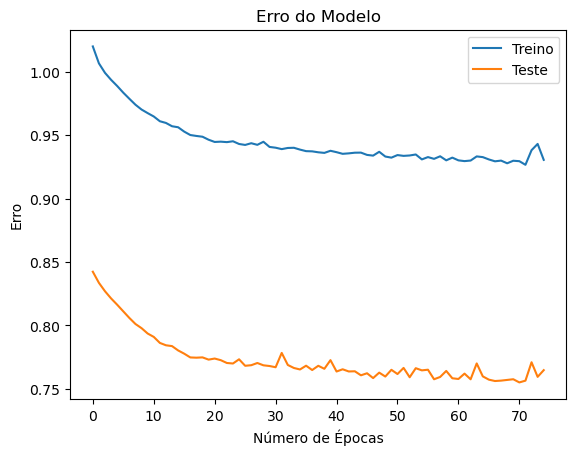

In [106]:
# Plot
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Erro do Modelo')
plt.ylabel('Erro')
plt.xlabel('Número de Épocas')
plt.legend(['Treino', 'Teste'], loc = 'upper right');

In [107]:
# Previsões
previsoes = autoencoder.predict(df_pca)
previsoes

33469/33469 ━━━━━━━━━━━━━━━━━━━━ 23s 698us/step


array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [17.446644,  0.      ,  0.      , ...,  0.      ,  0.      ,
        23.74652 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)

In [108]:
# Previsões em dataframe
df_previsoes = pd.DataFrame(previsoes, columns = cols_PCA)

In [109]:
# Visualiza
df_previsoes.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15
0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,17.446644,0.0,0.0,3.408667,16.675068,18.540327,0.0,6.466945,0.0,0.0,0.0,2.189610,0.0,0.0,23.746519
2,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.039219,0.0,0.0,0.000000
3,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,14.887509,0.0,0.0,6.140608,13.818472,15.431313,0.0,5.655629,0.0,0.0,0.0,1.472905,0.0,0.0,19.935431


In [110]:
# Shape
df_previsoes.shape

(1070994, 15)

In [111]:
# Colunas do PCA
cols_pca = ['PCA' + str(i) for i in range(1,16)]

In [112]:
# Dataframe
df_autoencod = pd.DataFrame(0, index = np.arange(len(df_previsoes)), columns = cols_pca)

In [113]:
# Loop
for i in range(0,15):
    df_autoencod.iloc[:,i] = (df_previsoes.iloc[:,i] - df_pca_scaled_z.iloc[:,i]) ** 2

In [114]:
# Calcula o score 2
df_autoencod['Fraud Score 2'] = df_autoencod[cols_pca].sum(axis = 1) ** (1 / 2)

In [115]:
# Visualiza
df_autoencod.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,Fraud Score 2
0,0.001810,0.005639,0.000371,0.000093,0.000466,0.011421,0.018429,0.004702,0.001618,0.000185,0.000800,0.005484,0.019568,0.002491,0.040827,0.337496
1,246.741430,82.138622,10.325188,12.488022,247.636762,219.737389,44.008407,29.784174,5.141913,6.856190,6.592255,4.627728,119.392208,97.380785,738.963481,43.264472
2,0.000003,0.005579,0.000055,0.003120,0.000062,0.005427,0.023519,0.004843,0.000821,0.000003,0.000205,0.018014,0.143008,0.003333,0.004666,0.461149
3,0.002981,0.004249,0.006204,0.001592,0.006532,0.000022,0.035781,0.001494,0.002360,0.000068,0.000171,0.043479,0.138172,0.004129,0.025081,0.521838
4,18.491935,10.182445,40.706721,0.513268,5.440422,56.030517,28.665074,246.086294,29.716839,71.067684,397.501616,1465.038603,491.512453,252.043288,193.295969,57.500375


In [116]:
# Dataframe
df_score2 = pd.merge(df_score1.iloc[:,1:], df_autoencod.iloc[:,-1], left_index = True, right_index = True)

In [117]:
# Visualiza
df_score2.head()

,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,ind1_media_ind1_grupo_ZIP,ind2_media_ind2_grupo_ZIP,ind3_media_ind3_grupo_ZIP,ind4_media_ind4_grupo_ZIP,ind5_media_ind5_grupo_ZIP,ind6_media_ind6_grupo_ZIP,ind7_media_ind7_grupo_ZIP,ind8_media_ind8_grupo_ZIP,ind9_media_ind9_grupo_ZIP,ind1_media_ind1_grupo_TAXCLASS,ind2_media_ind2_grupo_TAXCLASS,ind3_media_ind3_grupo_TAXCLASS,ind4_media_ind4_grupo_TAXCLASS,ind5_media_ind5_grupo_TAXCLASS,ind6_media_ind6_grupo_TAXCLASS,ind7_media_ind7_grupo_TAXCLASS,ind8_media_ind8_grupo_TAXCLASS,ind9_media_ind9_grupo_TAXCLASS,ind1_media_ind1_grupo_B,ind2_media_ind2_grupo_B,ind3_media_ind3_grupo_B,ind4_media_ind4_grupo_B,ind5_media_ind5_grupo_B,ind6_media_ind6_grupo_B,ind7_media_ind7_grupo_B,ind8_media_ind8_grupo_B,ind9_media_ind9_grupo_B,ind1_media_ind1_grupo_All,ind2_media_ind2_grupo_All,ind3_media_ind3_grupo_All,ind4_media_ind4_grupo_All,ind5_media_ind5_grupo_All,ind6_media_ind6_grupo_All,ind7_media_ind7_grupo_All,ind8_media_ind8_grupo_All,ind9_media_ind9_grupo_All,Fraud Score 1,Fraud Score 2
0,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.0,1046.0,NaN,4.0,21400000.0,4225500.0,9630000.0,4225500.0,9630000.0,4600.0,1 LIBERTY ISLAND,10004,X3,382.0,318.0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,0.132660,0.441094,0.322599,0.184226,0.384974,0.166501,0.146181,0.475000,0.338867,0.181122,0.202588,0.096781,0.188290,0.125069,0.052332,0.180994,0.192591,0.093690,0.113485,0.316930,0.269246,0.234841,0.509053,0.269543,0.195845,0.540729,0.436376,0.119128,0.289884,0.155020,0.726529,0.782444,0.359470,0.601506,1.044168,0.571508,0.337496,0.337496
1,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.0,355.0,NaN,1.0,193800000.0,14310000.0,87210000.0,14310000.0,87210000.0,4600.0,1 ELLIS ISLAND,10004,X3,382.0,318.0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,65.552497,3.994576,11.685938,34.042590,1.303747,2.255473,72.233943,4.301636,12.275206,89.499403,1.834653,3.505826,34.793565,0.423556,0.708900,89.436367,1.744114,3.393859,56.077418,2.870139,9.753257,43.395542,1.723950,3.651318,96.774801,4.896879,15.807401,58.865620,2.625212,5.615499,134.253016,2.649810,4.869500,297.227681,9.456065,20.702466,54.802711,43.264472
2,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709.0,564.0,E,3.0,104686000.0,39008700.0,47108700.0,39008700.0,47108700.0,2191.0,MARGINAL STREET,10004,X1,709.0,564.0,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,0.848772,0.655497,0.639208,2.224391,1.079643,0.622592,0.935283,0.705885,0.671440,1.158835,0.301061,0.191765,2.273461,0.350750,0.195682,1.158019,0.286204,0.185640,0.726089,0.470980,0.533493,2.835527,1.427617,1.007895,1.253037,0.803562,0.864648,0.762190,0.430789,0.307162,8.772284,2.194329,1.344157,3.848494,1.551710,1.132402,0.451297,0.461149
3,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793.0,551.0,NaN,2.0,39200000.0,15255000.0,17640000.0,15255000.0,17640000.0,2191.0,PIER 6,10004,X1,85.0,551.0,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,0.290863,2.095670,3.065391,0.796091,3.604838,3.118173,0.320510,2.256763,3.219964,0.397118,0.962512,0.919629,0.813652,1.171126,0.980048,0.396838,0.915013,0.890258,0.248821,1.505758,2.558420,1.014811,4.766692,5.047916,0.429400,2.569044,4.146510,0.261193,1.377262,1.473027,3.139525,7.326682,6.732043,1.318830,4.960926,5.430557,0.521838,0.521838
4,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323.0,1260.0,NaN,1.0,272300000.0,121050000.0,122535000.0,121050000.0,122535000.0,2231.0,BATTERY PARK,10004,X1,89.0,57.0,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,2.169213,134.397201,393.172423,6.782141,264.085147,456.865570,2.390310,144.728204,412.998307,2.961645,61.726751,117.953247,6.931754,85.794966,143.593770,2.959559,58.680591,114.186101,1.855671,96.565594,328.147535,8.645484,349.200900,73

#### Calculando o Score Final do Score de Fraude

In [118]:
# Cópia do dataframe
df_fraudes = df_score2.copy()

In [119]:
# Calcula o Rank do Score 1
df_fraudes['Rank_Fraud Score 1'] = df_fraudes['Fraud Score 1'].rank(ascending = True, method = 'first')
df_fraudes.head()

,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,ind1_media_ind1_grupo_ZIP,ind2_media_ind2_grupo_ZIP,ind3_media_ind3_grupo_ZIP,ind4_media_ind4_grupo_ZIP,ind5_media_ind5_grupo_ZIP,ind6_media_ind6_grupo_ZIP,ind7_media_ind7_grupo_ZIP,ind8_media_ind8_grupo_ZIP,ind9_media_ind9_grupo_ZIP,ind1_media_ind1_grupo_TAXCLASS,ind2_media_ind2_grupo_TAXCLASS,ind3_media_ind3_grupo_TAXCLASS,ind4_media_ind4_grupo_TAXCLASS,ind5_media_ind5_grupo_TAXCLASS,ind6_media_ind6_grupo_TAXCLASS,ind7_media_ind7_grupo_TAXCLASS,ind8_media_ind8_grupo_TAXCLASS,ind9_media_ind9_grupo_TAXCLASS,ind1_media_ind1_grupo_B,ind2_media_ind2_grupo_B,ind3_media_ind3_grupo_B,ind4_media_ind4_grupo_B,ind5_media_ind5_grupo_B,ind6_media_ind6_grupo_B,ind7_media_ind7_grupo_B,ind8_media_ind8_grupo_B,ind9_media_ind9_grupo_B,ind1_media_ind1_grupo_All,ind2_media_ind2_grupo_All,ind3_media_ind3_grupo_All,ind4_media_ind4_grupo_All,ind5_media_ind5_grupo_All,ind6_media_ind6_grupo_All,ind7_media_ind7_grupo_All,ind8_media_ind8_grupo_All,ind9_media_ind9_grupo_All,Fraud Score 1,Fraud Score 2,Rank_Fraud Score 1
0,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.0,1046.0,NaN,4.0,21400000.0,4225500.0,9630000.0,4225500.0,9630000.0,4600.0,1 LIBERTY ISLAND,10004,X3,382.0,318.0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,0.132660,0.441094,0.322599,0.184226,0.384974,0.166501,0.146181,0.475000,0.338867,0.181122,0.202588,0.096781,0.188290,0.125069,0.052332,0.180994,0.192591,0.093690,0.113485,0.316930,0.269246,0.234841,0.509053,0.269543,0.195845,0.540729,0.436376,0.119128,0.289884,0.155020,0.726529,0.782444,0.359470,0.601506,1.044168,0.571508,0.337496,0.337496,634057.0
1,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.0,355.0,NaN,1.0,193800000.0,14310000.0,87210000.0,14310000.0,87210000.0,4600.0,1 ELLIS ISLAND,10004,X3,382.0,318.0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,65.552497,3.994576,11.685938,34.042590,1.303747,2.255473,72.233943,4.301636,12.275206,89.499403,1.834653,3.505826,34.793565,0.423556,0.708900,89.436367,1.744114,3.393859,56.077418,2.870139,9.753257,43.395542,1.723950,3.651318,96.774801,4.896879,15.807401,58.865620,2.625212,5.615499,134.253016,2.649810,4.869500,297.227681,9.456065,20.702466,54.802711,43.264472,1070733.0
2,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709.0,564.0,E,3.0,104686000.0,39008700.0,47108700.0,39008700.0,47108700.0,2191.0,MARGINAL STREET,10004,X1,709.0,564.0,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,0.848772,0.655497,0.639208,2.224391,1.079643,0.622592,0.935283,0.705885,0.671440,1.158835,0.301061,0.191765,2.273461,0.350750,0.195682,1.158019,0.286204,0.185640,0.726089,0.470980,0.533493,2.835527,1.427617,1.007895,1.253037,0.803562,0.864648,0.762190,0.430789,0.307162,8.772284,2.194329,1.344157,3.848494,1.551710,1.132402,0.451297,0.461149,892298.0
3,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793.0,551.0,NaN,2.0,39200000.0,15255000.0,17640000.0,15255000.0,17640000.0,2191.0,PIER 6,10004,X1,85.0,551.0,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,0.290863,2.095670,3.065391,0.796091,3.604838,3.118173,0.320510,2.256763,3.219964,0.397118,0.962512,0.919629,0.813652,1.171126,0.980048,0.396838,0.915013,0.890258,0.248821,1.505758,2.558420,1.014811,4.766692,5.047916,0.429400,2.569044,4.146510,0.261193,1.377262,1.473027,3.139525,7.326682,6.732043,1.318830,4.960926,5.430557,0.521838,0.521838,926804.0
4,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323.0,1260.0,NaN,1.0,272300000.0,121050000.0,122535000.0,121050000.0,122535000.0,2231.0,BATTERY PARK,10004,X1,89.0,57.0,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,2.169213,134.397201,393.172423,6.782141,264.085147,456.865570,2.390310,144.728204,412.998307,2.961645,61.726751,117.953247,6.931754,85.794966,143.593770,2.959559,58.680591,114.186

In [120]:
# Calcula o Rank do Score 2
df_fraudes['Rank_Fraud Score 2'] = df_fraudes['Fraud Score 2'].rank(ascending = True, method = 'first')
df_fraudes.head()

,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,ind1_media_ind1_grupo_ZIP,ind2_media_ind2_grupo_ZIP,ind3_media_ind3_grupo_ZIP,ind4_media_ind4_grupo_ZIP,ind5_media_ind5_grupo_ZIP,ind6_media_ind6_grupo_ZIP,ind7_media_ind7_grupo_ZIP,ind8_media_ind8_grupo_ZIP,ind9_media_ind9_grupo_ZIP,ind1_media_ind1_grupo_TAXCLASS,ind2_media_ind2_grupo_TAXCLASS,ind3_media_ind3_grupo_TAXCLASS,ind4_media_ind4_grupo_TAXCLASS,ind5_media_ind5_grupo_TAXCLASS,ind6_media_ind6_grupo_TAXCLASS,ind7_media_ind7_grupo_TAXCLASS,ind8_media_ind8_grupo_TAXCLASS,ind9_media_ind9_grupo_TAXCLASS,ind1_media_ind1_grupo_B,ind2_media_ind2_grupo_B,ind3_media_ind3_grupo_B,ind4_media_ind4_grupo_B,ind5_media_ind5_grupo_B,ind6_media_ind6_grupo_B,ind7_media_ind7_grupo_B,ind8_media_ind8_grupo_B,ind9_media_ind9_grupo_B,ind1_media_ind1_grupo_All,ind2_media_ind2_grupo_All,ind3_media_ind3_grupo_All,ind4_media_ind4_grupo_All,ind5_media_ind5_grupo_All,ind6_media_ind6_grupo_All,ind7_media_ind7_grupo_All,ind8_media_ind8_grupo_All,ind9_media_ind9_grupo_All,Fraud Score 1,Fraud Score 2,Rank_Fraud Score 1,Rank_Fraud Score 2
0,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.0,1046.0,NaN,4.0,21400000.0,4225500.0,9630000.0,4225500.0,9630000.0,4600.0,1 LIBERTY ISLAND,10004,X3,382.0,318.0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,0.132660,0.441094,0.322599,0.184226,0.384974,0.166501,0.146181,0.475000,0.338867,0.181122,0.202588,0.096781,0.188290,0.125069,0.052332,0.180994,0.192591,0.093690,0.113485,0.316930,0.269246,0.234841,0.509053,0.269543,0.195845,0.540729,0.436376,0.119128,0.289884,0.155020,0.726529,0.782444,0.359470,0.601506,1.044168,0.571508,0.337496,0.337496,634057.0,667630.0
1,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.0,355.0,NaN,1.0,193800000.0,14310000.0,87210000.0,14310000.0,87210000.0,4600.0,1 ELLIS ISLAND,10004,X3,382.0,318.0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,65.552497,3.994576,11.685938,34.042590,1.303747,2.255473,72.233943,4.301636,12.275206,89.499403,1.834653,3.505826,34.793565,0.423556,0.708900,89.436367,1.744114,3.393859,56.077418,2.870139,9.753257,43.395542,1.723950,3.651318,96.774801,4.896879,15.807401,58.865620,2.625212,5.615499,134.253016,2.649810,4.869500,297.227681,9.456065,20.702466,54.802711,43.264472,1070733.0,1070732.0
2,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709.0,564.0,E,3.0,104686000.0,39008700.0,47108700.0,39008700.0,47108700.0,2191.0,MARGINAL STREET,10004,X1,709.0,564.0,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,0.848772,0.655497,0.639208,2.224391,1.079643,0.622592,0.935283,0.705885,0.671440,1.158835,0.301061,0.191765,2.273461,0.350750,0.195682,1.158019,0.286204,0.185640,0.726089,0.470980,0.533493,2.835527,1.427617,1.007895,1.253037,0.803562,0.864648,0.762190,0.430789,0.307162,8.772284,2.194329,1.344157,3.848494,1.551710,1.132402,0.451297,0.461149,892298.0,921517.0
3,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793.0,551.0,NaN,2.0,39200000.0,15255000.0,17640000.0,15255000.0,17640000.0,2191.0,PIER 6,10004,X1,85.0,551.0,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,0.290863,2.095670,3.065391,0.796091,3.604838,3.118173,0.320510,2.256763,3.219964,0.397118,0.962512,0.919629,0.813652,1.171126,0.980048,0.396838,0.915013,0.890258,0.248821,1.505758,2.558420,1.014811,4.766692,5.047916,0.429400,2.569044,4.146510,0.261193,1.377262,1.473027,3.139525,7.326682,6.732043,1.318830,4.960926,5.430557,0.521838,0.521838,926804.0,948112.0
4,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323.0,1260.0,NaN,1.0,272300000.0,121050000.0,122535000.0,121050000.0,122535000.0,2231.0,BATTERY PARK,10004,X1,89.0,57.0,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,2.169213,134.397201,393.172423,6.782141,264.085147,456.865570,2.390310,144.728204,412.998307,2.961645,61.726751,117.953247,

In [121]:
# Organiza os dados
df_fraudes.sort_values('Rank_Fraud Score 1', ascending = False).head()

,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,ind1_media_ind1_grupo_ZIP,ind2_media_ind2_grupo_ZIP,ind3_media_ind3_grupo_ZIP,ind4_media_ind4_grupo_ZIP,ind5_media_ind5_grupo_ZIP,ind6_media_ind6_grupo_ZIP,ind7_media_ind7_grupo_ZIP,ind8_media_ind8_grupo_ZIP,ind9_media_ind9_grupo_ZIP,ind1_media_ind1_grupo_TAXCLASS,ind2_media_ind2_grupo_TAXCLASS,ind3_media_ind3_grupo_TAXCLASS,ind4_media_ind4_grupo_TAXCLASS,ind5_media_ind5_grupo_TAXCLASS,ind6_media_ind6_grupo_TAXCLASS,ind7_media_ind7_grupo_TAXCLASS,ind8_media_ind8_grupo_TAXCLASS,ind9_media_ind9_grupo_TAXCLASS,ind1_media_ind1_grupo_B,ind2_media_ind2_grupo_B,ind3_media_ind3_grupo_B,ind4_media_ind4_grupo_B,ind5_media_ind5_grupo_B,ind6_media_ind6_grupo_B,ind7_media_ind7_grupo_B,ind8_media_ind8_grupo_B,ind9_media_ind9_grupo_B,ind1_media_ind1_grupo_All,ind2_media_ind2_grupo_All,ind3_media_ind3_grupo_All,ind4_media_ind4_grupo_All,ind5_media_ind5_grupo_All,ind6_media_ind6_grupo_All,ind7_media_ind7_grupo_All,ind8_media_ind8_grupo_All,ind9_media_ind9_grupo_All,Fraud Score 1,Fraud Score 2,Rank_Fraud Score 1,Rank_Fraud Score 2
632815,4018420001,4,1842,1,NaN,"864163 REALTY, LLC",D9,2,157.0,95.0,NaN,1.0,2.930000e+06,1.318500e+06,1.318500e+06,NaN,NaN,NaN,86-55 BROADWAY,11373,NaN,1.0,1.0,1.201200e+06,1.201200e+06,NaN,NaN,NaN,FINAL,2010/11,AC-TR,0.932428,3552.078084,5458.560238,11.867480,8665.774368,9226.511352,4.729417,7524.423324,8650.459570,2.374901,20917.627942,85252.370375,9.574238,60709.723730,142805.971089,2.376405,20929.365242,85293.645699,0.345363,4291.496415,8507.418177,9.777635,24759.415131,44494.613863,3.047681,16039.517716,31615.634824,0.571932,4821.350855,10313.181717,7.949383,29658.268451,54502.365585,2.887832,17366.599665,38021.252085,1032.370884,1024.639358,1070994.0,1070994.0
776305,4080100001,4,8010,1,NaN,TONY CHEN,Q9,4,6.0,1.0,NaN,1.0,4.772500e+06,2.139750e+06,2.147625e+06,NaN,NaN,NaN,SHORE ROAD,1,NaN,30.0,44.0,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1888.840845,0.692436,1.160253,2045.663004,0.887572,1.274666,2040.849109,0.880413,1.258085,3520.895787,4.157791,7.945096,8311.189796,5.828422,9.754944,3518.415931,3.952608,7.691348,1398.384315,5.295575,10.497894,39444.708454,30.440330,54.703663,12340.133042,19.792274,39.012726,2315.766427,5.949399,12.726151,32069.214226,36.463198,67.007640,11692.901316,21.429852,46.917061,1021.876097,1019.530897,1070993.0,1070993.0
565391,3085900700,3,8590,700,NaN,U S GOVERNMENT OWNRD,V9,4,117.0,108.0,NaN,2.0,4.326304e+09,1.946837e+09,1.946837e+09,1.946837e+09,1.946837e+09,2231.0,FLATBUSH AVENUE,11234,X1,20.0,52.0,8.484847e+08,8.484847e+08,8.484847e+08,8.484847e+08,NaN,FINAL,2010/11,AC-TR,1618.539043,4000.940895,3587.207338,9974.557033,9863.008217,8951.712598,7670.679540,8931.292755,8108.728188,1515.534649,4783.814206,4570.679703,3590.635455,6730.666200,5632.508410,1514.467220,4547.737262,4424.703094,1402.682203,6628.430785,7085.501899,20457.177529,54989.065573,47953.485331,8403.349623,33254.611276,32965.193831,996.798676,6845.178539,7321.140099,13854.677903,42107.730551,38690.237905,5033.093327,24656.466391,26990.595231,925.736545,925.736545,1070992.0,1070992.0
1067359,5078530085,5,7853,85,NaN,NaN,B2,1,1.0,1.0,NaN,2.0,8.360000e+05,2.880000e+04,5.016000e+04,NaN,NaN,NaN,20 EMILY COURT,10307,NaN,36.0,45.0,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,2605.302920,0.304848,0.336873,2708.527356,0.323936,0.347648,2651.316110,0.343571,0.373297,3632.533954,0.730567,0.752414,4978.130935,0.972196,0.982669,5152.149989,1.004425,1.021688,6293.782225,0.912347,0.885684,6407.341828,0.520325,0.498889,6037.904502,0.626119,0.604372,2433.920251,0.849166,0.908210,2589.816669,0.399892,0.367437,1638.598722,0.407828,0.446436,916.675186,916.675186,1070991.0,1070991.0
917941,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910.0,100.0,NaN,3.0,3.740199e+08,1.792809e+09,4.668309e+09,1.792809e+09,4.668309e+09,2198.0,154-

In [122]:
# Score final
df_fraudes['Final Score'] = (df_fraudes['Fraud Score 1'] * df_fraudes['Rank_Fraud Score 1']) + (df_fraudes['Fraud Score 2'] * df_fraudes['Rank_Fraud Score 2'])

In [123]:
# Rank do Score Final
df_fraudes['Final Rank'] = df_fraudes['Final Score'].rank(ascending = False, method = 'first')

In [124]:
# Resultado
df_fraudes.sort_values('Final Rank', ascending = True).head(20)

,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,ind1_media_ind1_grupo_ZIP,ind2_media_ind2_grupo_ZIP,ind3_media_ind3_grupo_ZIP,ind4_media_ind4_grupo_ZIP,ind5_media_ind5_grupo_ZIP,ind6_media_ind6_grupo_ZIP,ind7_media_ind7_grupo_ZIP,ind8_media_ind8_grupo_ZIP,ind9_media_ind9_grupo_ZIP,ind1_media_ind1_grupo_TAXCLASS,ind2_media_ind2_grupo_TAXCLASS,ind3_media_ind3_grupo_TAXCLASS,ind4_media_ind4_grupo_TAXCLASS,ind5_media_ind5_grupo_TAXCLASS,ind6_media_ind6_grupo_TAXCLASS,ind7_media_ind7_grupo_TAXCLASS,ind8_media_ind8_grupo_TAXCLASS,ind9_media_ind9_grupo_TAXCLASS,ind1_media_ind1_grupo_B,ind2_media_ind2_grupo_B,ind3_media_ind3_grupo_B,ind4_media_ind4_grupo_B,ind5_media_ind5_grupo_B,ind6_media_ind6_grupo_B,ind7_media_ind7_grupo_B,ind8_media_ind8_grupo_B,ind9_media_ind9_grupo_B,ind1_media_ind1_grupo_All,ind2_media_ind2_grupo_All,ind3_media_ind3_grupo_All,ind4_media_ind4_grupo_All,ind5_media_ind5_grupo_All,ind6_media_ind6_grupo_All,ind7_media_ind7_grupo_All,ind8_media_ind8_grupo_All,ind9_media_ind9_grupo_All,Fraud Score 1,Fraud Score 2,Rank_Fraud Score 1,Rank_Fraud Score 2,Final Score,Final Rank
632815,4018420001,4,1842,1,NaN,"864163 REALTY, LLC",D9,2,157.0,95.0,NaN,1.0,2.930000e+06,1.318500e+06,1.318500e+06,NaN,NaN,NaN,86-55 BROADWAY,11373,NaN,1.0,1.0,1.201200e+06,1.201200e+06,NaN,NaN,NaN,FINAL,2010/11,AC-TR,0.932428,3552.078084,5458.560238,11.867480,8665.774368,9226.511352,4.729417,7524.423324,8650.459570,2.374901,20917.627942,85252.370375,9.574238,60709.723730,142805.971089,2.376405,20929.365242,85293.645699,0.345363,4291.496415,8507.418177,9.777635,24759.415131,44494.613863,3.047681,16039.517716,31615.634824,0.571932,4821.350855,10313.181717,7.949383,29658.268451,54502.365585,2.887832,17366.599665,38021.252085,1032.370884,1024.639358,1070994.0,1070994.0,2.203046e+09,1.0
776305,4080100001,4,8010,1,NaN,TONY CHEN,Q9,4,6.0,1.0,NaN,1.0,4.772500e+06,2.139750e+06,2.147625e+06,NaN,NaN,NaN,SHORE ROAD,1,NaN,30.0,44.0,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1888.840845,0.692436,1.160253,2045.663004,0.887572,1.274666,2040.849109,0.880413,1.258085,3520.895787,4.157791,7.945096,8311.189796,5.828422,9.754944,3518.415931,3.952608,7.691348,1398.384315,5.295575,10.497894,39444.708454,30.440330,54.703663,12340.133042,19.792274,39.012726,2315.766427,5.949399,12.726151,32069.214226,36.463198,67.007640,11692.901316,21.429852,46.917061,1021.876097,1019.530897,1070993.0,1070993.0,2.186333e+09,2.0
565391,3085900700,3,8590,700,NaN,U S GOVERNMENT OWNRD,V9,4,117.0,108.0,NaN,2.0,4.326304e+09,1.946837e+09,1.946837e+09,1.946837e+09,1.946837e+09,2231.0,FLATBUSH AVENUE,11234,X1,20.0,52.0,8.484847e+08,8.484847e+08,8.484847e+08,8.484847e+08,NaN,FINAL,2010/11,AC-TR,1618.539043,4000.940895,3587.207338,9974.557033,9863.008217,8951.712598,7670.679540,8931.292755,8108.728188,1515.534649,4783.814206,4570.679703,3590.635455,6730.666200,5632.508410,1514.467220,4547.737262,4424.703094,1402.682203,6628.430785,7085.501899,20457.177529,54989.065573,47953.485331,8403.349623,33254.611276,32965.193831,996.798676,6845.178539,7321.140099,13854.677903,42107.730551,38690.237905,5033.093327,24656.466391,26990.595231,925.736545,925.736545,1070992.0,1070992.0,1.982913e+09,3.0
1067359,5078530085,5,7853,85,NaN,NaN,B2,1,1.0,1.0,NaN,2.0,8.360000e+05,2.880000e+04,5.016000e+04,NaN,NaN,NaN,20 EMILY COURT,10307,NaN,36.0,45.0,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,2605.302920,0.304848,0.336873,2708.527356,0.323936,0.347648,2651.316110,0.343571,0.373297,3632.533954,0.730567,0.752414,4978.130935,0.972196,0.982669,5152.149989,1.004425,1.021688,6293.782225,0.912347,0.885684,6407.341828,0.520325,0.498889,6037.904502,0.626119,0.604372,2433.920251,0.849166,0.908210,2589.816669,0.399892,0.367437,1638.598722,0.407828,0.446436,916.675186,916.675186,1070991.0,1070991.0,1.963502e+09,4.0
917941,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910.0